# DATA CHALLENGE

We have anonymous clicks and conversion data saved across multiple csv files for each day. Firstly, let us try to find out the total number of rows of data that we are dealing with here.

**Note** I am using Google collab for this challenge so the kernel memory i have is limited to 12GB of RAM.

In [1]:
# Get the total number of rows
!cat datachallenge_2019/data*.csv | wc -l

74391845


We have 12GB of data across multiple csv files. A total of  74+ million rows of data.  This extends my kernel memory (12GB RAM).

## EDA and Feature Engineering

Before directly starting with the modelling task, it is always good to explore our dataset and find out useful insights about our data. So, in the following section my aim will be to detaily investigate the data.

### Importing Libraries

In [0]:
import glob
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

We have seen earlier that we have a total of 74 million records. As this is a BIG dataset,  for this analysis, I am going to use the first 100000 rows from every csv files. Also, only import the selected columns which is important for the prediction task. <br/>

Following are the columns we need: <br/>

* 'ts',
* 'event_type',
* 'country',
* 'device_type', 
* 'os',
* 'os_version',
* 'partner',
* 'publisher_app',
* 'organization',
* 'audience',
* 'campaign',
* 'ad_type',
* 'ad_size',
* 'conversion_cpx_eur'

In [3]:
# Loading clicks and conversion data
cols = ['ts', 'event_type', 'country', 'device_type', 'os', 'os_version', 'partner', 'publisher_app', 'organization', 'audience', 'campaign', 'ad_type', 'ad_size', 'conversion_cpx_eur']

path =r'/content/datachallenge_2019/' # use your path
allFiles = glob.glob(path + "data*.csv")

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_, nrows=100000, usecols=cols, index_col=None, header=0)
    list_.append(df)

clicks_data = pd.concat(list_, axis = 0, ignore_index = True)

clicks_data.head()

,ts,event_type,country,device_type,os,os_version,partner,publisher_app,organization,audience,campaign,ad_type,ad_size,conversion_cpx_eur
0,2018-06-06T03:20:31.000Z,click,Mathew,android,android,8.1,Jodi,240091,Gabriela,4425,42357,1,320x480,NaN
1,2018-06-06T03:20:31.000Z,click,Elena,android,android,8.0,Glenda,828268,Tiffany,5877,40674,4,480x320,NaN
2,2018-06-06T03:20:32.000Z,conversion,Elena,android,android,7.0,Glenda,394307,Rick,6798,47040,2,native,175299.0
3,2018-06-06T03:20:36.000Z,click,Braxton,android,android,7.1,Jaylon,23577,Tiffany,5874,40677,2,native,NaN
4,2018-06-06T03:20:38.000Z,conversion,Tonya,iphone,ios,12.0,Jodi,308614,Taryn,5412,44274,1,480x320,12270992.0


It is given to us that there is another file campaign_data.csv containing campaign_id and conversion_event data.

In [4]:
# Loading the campaign data
campaign_df = pd.read_csv('/content/datachallenge_2019/campaign_data.csv', index_col=0)

campaign_df.head()

,campaign_id,conversion_event
0,8553,Balkanizes
1,8604,Balkanizes
2,8613,Velcros
3,15351,accending
4,11622,accites


Also, we have already obtained information that each campaign will have one conversion event defined (i.e we can think of it as, campaign_id having a foreign key relationship with campaign from the data we collected earlier) , we merge the two dataframes on the campaign. Note that we make a left join here as we want to return all the rows from the clicks_data dataframe.

In [5]:
data = pd.merge(clicks_data, campaign_df.rename(columns={"campaign_id": "campaign"}), how='left', on='campaign')

# Clear memory
del clicks_data
del campaign_df
gc.collect()
data.head()

,ts,event_type,country,device_type,os,os_version,partner,publisher_app,organization,audience,campaign,ad_type,ad_size,conversion_cpx_eur,conversion_event
0,2018-06-06T03:20:31.000Z,click,Mathew,android,android,8.1,Jodi,240091,Gabriela,4425,42357,1,320x480,NaN,argufied
1,2018-06-06T03:20:31.000Z,click,Elena,android,android,8.0,Glenda,828268,Tiffany,5877,40674,4,480x320,NaN,canalise
2,2018-06-06T03:20:32.000Z,conversion,Elena,android,android,7.0,Glenda,394307,Rick,6798,47040,2,native,175299.0,astrogate
3,2018-06-06T03:20:36.000Z,click,Braxton,android,android,7.1,Jaylon,23577,Tiffany,5874,40677,2,native,NaN,canalise
4,2018-06-06T03:20:38.000Z,conversion,Tonya,iphone,ios,12.0,Jodi,308614,Taryn,5412,44274,1,480x320,12270992.0,accending


### Data insights

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6100000 entries, 0 to 6099999
Data columns (total 15 columns):
ts                    object
event_type            object
country               object
device_type           object
os                    object
os_version            float64
partner               object
publisher_app         int64
organization          object
audience              int64
campaign              int64
ad_type               int64
ad_size               object
conversion_cpx_eur    float64
conversion_event      object
dtypes: float64(2), int64(4), object(9)
memory usage: 744.6+ MB


Apart from 'ts', the datatype of all other columns look okay. We have to change the datatype of this column to Datetime format. Also, we will split the timestamp into Month, Day, Hour, Minute, Second.<br/>

We do this to understand the data distribution better in terms of Month, Day etc. 

In [0]:
data['ts'] = pd.to_datetime(data['ts'])

data['month'] = data['ts'].dt.month.astype('uint8')
data['day'] = data['ts'].dt.day.astype('uint8')
data['hour'] = data['ts'].dt.hour.astype('uint8')
data['minute'] = data['ts'].dt.minute.astype('uint8')
data['second'] = data['ts'].dt.second.astype('uint8')
data.drop(['ts'], axis=1, inplace=True)

In [8]:
data.columns.values

array(['event_type', 'country', 'device_type', 'os', 'os_version',
       'partner', 'publisher_app', 'organization', 'audience', 'campaign',
       'ad_type', 'ad_size', 'conversion_cpx_eur', 'conversion_event',
       'month', 'day', 'hour', 'minute', 'second'], dtype=object)

conversion_event is our dependent variable and the rest are independent variable


### To check missing values

['os', 'os_version', 'conversion_cpx_eur']

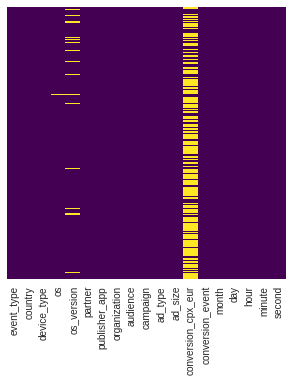

In [9]:
plt.figure(figsize=(5, 5))
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')
data.columns[data.isna().any()].tolist()

We see that missing values in the os and os_version comprises of a very small part of the data. So it is safe to remove them off from our dataset and further continue investigation.

In [0]:
data = data[data['os'].notnull()]
data = data[np.isfinite(data['os_version'])]

Now let us see the behaviour of different event_type against conversion_cpx_eur.

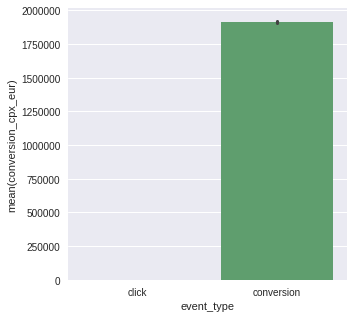

In [11]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(x=data.event_type, y=data.conversion_cpx_eur)

The conversion_cpx_eur data only exist for conversion type event and are missing 'nan' values for click event which makes sense because, there is no cost to determine for click event. We replace the missing values by 0.0

In [0]:
data.conversion_cpx_eur.fillna(0.0, inplace=True)

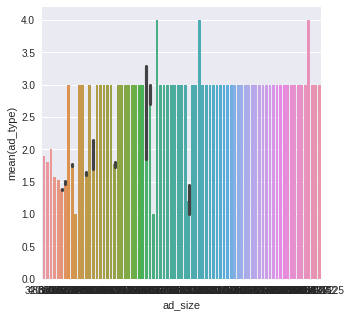

In [13]:
# clearing the memory
gc.collect()

plt.figure(figsize=(5, 5))
ax = sns.barplot(x=data.ad_size, y=data.ad_type)

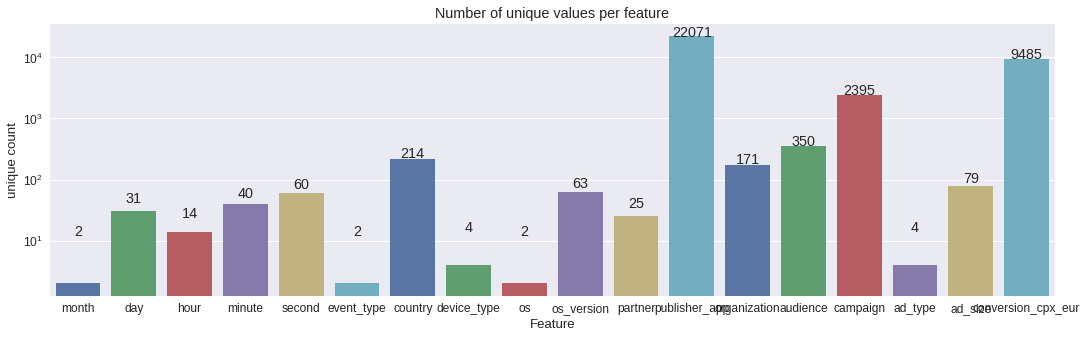

In [14]:
plt.figure(figsize=(18, 5))
cols = ['month', 'day', 'hour', 'minute', 'second', 'event_type', 'country', 'device_type', 'os', 'os_version', 'partner', 'publisher_app', 'organization', 'audience', 'campaign', 'ad_type', 'ad_size', 'conversion_cpx_eur']
uniques = [len(data[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='unique count', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

We are dealing with categorical data.<br/>

* 'month', 'day', 'hour', 'minute', 'second', 'conversion_cpx_eur' are ordinal data type. This means that there is some sense of meaningful ordering in this kind of attribute.

* 'event_type', 'country', 'device_type', 'os', 'os_version', 'partner', 'publisher_app', 'organization', 'audience', 'campaign', 'ad_type', 'ad_size' are nominal data type. These do not have any kind of order in them.

### To check distribution-Skewness

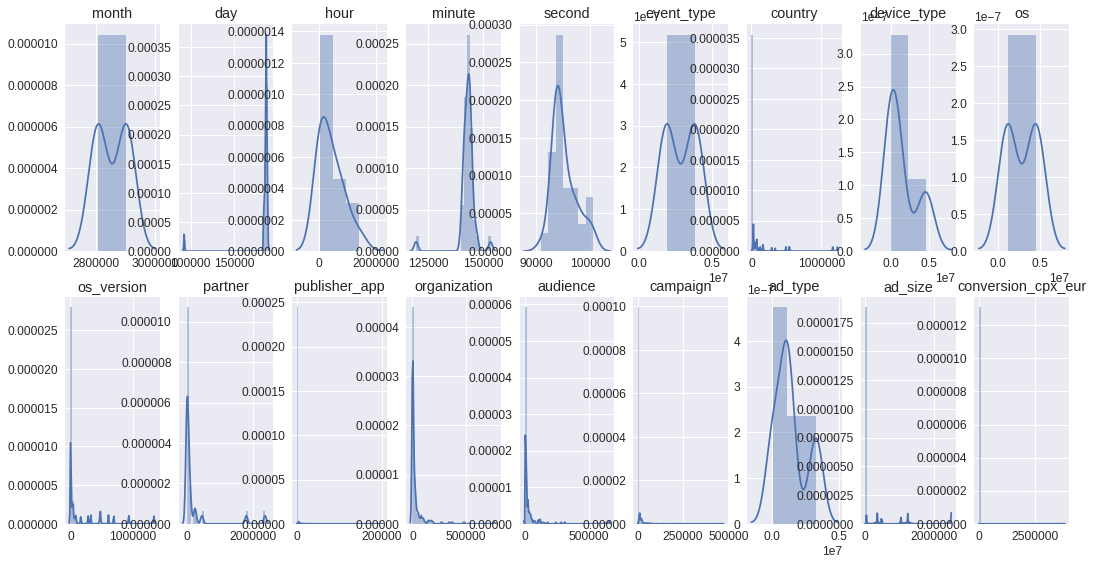

In [15]:
gc.collect()

l = cols
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    ax = sns.distplot(data[l[i]].value_counts().values,kde=True)
    ax.set_title(l[i])

Most of the data distribution is right skewed.<br/>
Minute and second appears to have a slightly normal distribution.<br/>

### Understanding Target variable

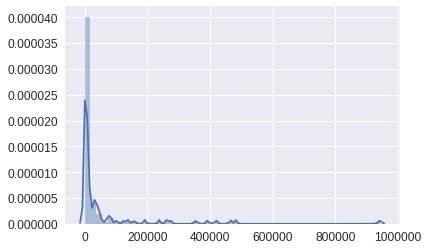

In [16]:
plt.figure(figsize=(6,4))
sns.distplot(data.conversion_event.value_counts().values,kde=True) 

It looks like we have an imbalanced data distribution, Some conversion_event have a lot of datapoints while some have only 1 or 2 datapoints.

In [17]:
data.conversion_event.nunique()

print(data.conversion_event.value_counts()[:5,])
print(data.conversion_event.value_counts()[-5:,])

accites      941579
canalise     482677
accending    465761
argufied     419228
astrogate    392170
Name: conversion_event, dtype: int64
roarest       1
quadded       1
respecify     1
biomagnify    1
misgoverns    1
Name: conversion_event, dtype: int64


There is a total of 135 labels to predict from. Some conversion_event like accites has over 900 thousand samples while misgoverns, quadded have only a single sample.

## Encoding the categorical variables

We perform a pre-processing step that converts string valued attributes in to numerical representations.

**For Ordinal data:**

* Label encoding: Label encoding is done on ordinal data so that it will not lose it's ranking or level of importance.

**For Nominal data: **

* One hot encoding: Every data is treated equally. Creates one column for each value to compare vs. all other values.

* Drawback: For high cardinality categorical data, it will increase the dimensionality of the data. Hence, suffer from curse of curse of dimensionality.

I will be just label encoding my categorys as i plan to use a decision tree for modelling which will be explained further below

In [0]:
from sklearn.preprocessing import LabelEncoder

cols = ['month', 'day', 'hour', 'minute', 'second', 'event_type', 'country', 'device_type', 'os', 'os_version', 'partner', 'publisher_app', 'organization', 'audience', 'campaign', 'ad_type', 'ad_size', 'conversion_cpx_eur']


lb_make = LabelEncoder()

for col in cols:
  data[col] = lb_make.fit_transform(data[col])

data["conversion_event"] = lb_make.fit_transform(data['conversion_event'])

In [20]:
data.tail()

,event_type,country,device_type,os,os_version,partner,publisher_app,organization,audience,campaign,ad_type,ad_size,conversion_cpx_eur,conversion_event,month,day,hour,minute,second
6099995,1,193,0,0,22,11,15165,135,244,1305,0,38,3179,55,1,8,10,30,1
6099996,1,61,2,1,42,19,11727,0,38,1431,0,39,4303,18,1,8,10,30,7
6099997,0,127,0,0,23,8,21155,124,316,1936,0,39,0,17,1,8,10,30,6
6099998,0,193,2,1,42,8,3975,53,202,967,0,39,0,32,1,8,10,30,8
6099999,0,54,0,0,23,11,3320,156,208,775,3,38,0,23,1,8,10,30,13


Correlation can be a great way of finding similar category. It can be useful in meaning a statistical relationship between two variables. From the correlation plot below we can see that device_type, os, os_version are closely related.

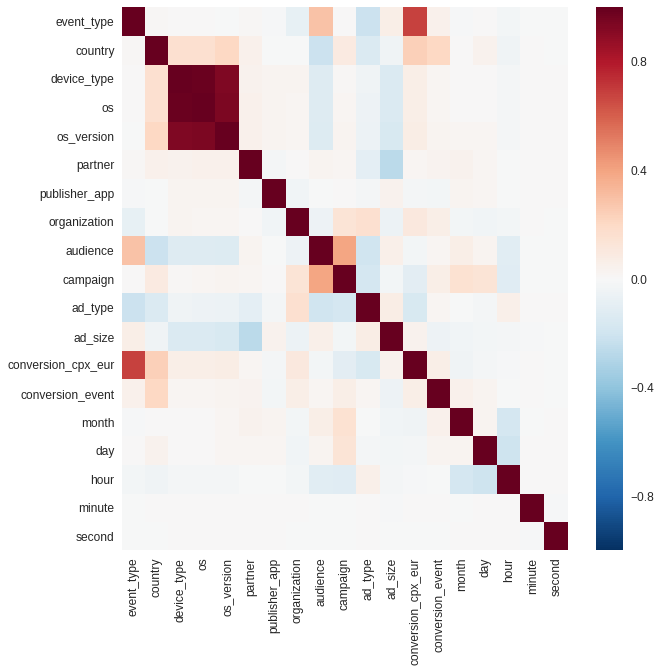

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), fmt=".2f")
plt.show()

## Data preparation

In this section we will perform test train split on our data. We will train the model on 80 percent of the data and then test the model using the 20 percent of the data.

In [0]:
# We make all the independent variables as type category
for c in data.columns:
  data[c] = data[c].astype('category')

In [0]:
data.sample(frac=1)
data_train, data_test = train_test_split(data, test_size=0.20, random_state=314)
data_train, data_valid = train_test_split(data_train, test_size=0.10, random_state=76)

# Creating training sets
y_train = data_train['conversion_event']
data_train.drop(['conversion_event'], axis=1, inplace=True)
x_train = data_train

# Creating validation sets
y_valid = data_valid['conversion_event']
data_valid.drop(['conversion_event'], axis=1, inplace=True)
x_valid = data_valid

# Creating test sets
y_test = data_test['conversion_event']
data_test.drop(['conversion_event'], axis=1, inplace=True)
x_test = data_test

## Modelling

We will be using LightGBM for modelling the data.

What is LightGBM?

LightGBM is a gradient boosting framework that uses tree based learning algorithms and is used for ranking, classification as well as many other machine learning tasks.

https://github.com/Microsoft/LightGBM

Why LightGBM?

* It provides higher accuracy.
* Data of large-scale with higher dimensionality can be handled.
* Higher efficiency as well as faster training speed
* Usage of lower memory

Contrast to other tree algorithms  which grow horizontally, Light GBM grows tree vertically, that is Light GBM grows tree leaf-wise while other algorithms grow level-wise. Light GBM will choose the leaf that has a max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss when compared to a level-wise algorithm.

In [0]:
# Specifying the categories and predictors
predictors = cols
categorical = ["event_type", "country", "device_type", "os", "os_version", "partner", "publisher_app", "organization", "audience", "campaign", "ad_type", "ad_size"]
gc.collect()

We will have to specify the core parameters for the model. Some of the important ones are as below:

* boosting_type: gbdt - traditional Gradient Boosting Decision Tree
* objective: multi class classification
* metric: multi_error - error rate for multi-class classification
* num_class: number of classes to predict from - 135
* num_leaves: max number of leaves in one tree
* max_depth: limit the max depth for tree model
* learning_rate: learning rate

In [0]:
# specify the configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'metric': 'multi_error',
    'num_class': 135, 
    'num_leaves': 255,
    'max_depth': 8,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

We will now initialize the training and validation datasets as below

In [0]:
dtrain = lgb.Dataset(x_train, label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                    )


dvalid = lgb.Dataset(x_valid, label=y_valid,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

Now we begin training our model. We stop training if there's no improvement in metric after specified early_stopping_rounds (10).

In [35]:
evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid],  
                 evals_result=evals_results, 
                 num_boost_round=100,
                 early_stopping_rounds=10,
                 verbose_eval=True)

Training the model...
[1]	training's multi_error: 0.0398562	valid_1's multi_error: 0.0401634
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_error: 0.0198431	valid_1's multi_error: 0.0197883
[3]	training's multi_error: 0.129789	valid_1's multi_error: 0.130368
[4]	training's multi_error: 0.165461	valid_1's multi_error: 0.165687
[5]	training's multi_error: 0.222612	valid_1's multi_error: 0.222427
[6]	training's multi_error: 0.0354809	valid_1's multi_error: 0.0350581
[7]	training's multi_error: 0.0092424	valid_1's multi_error: 0.00903272
[8]	training's multi_error: 0.0140161	valid_1's multi_error: 0.0139497
[9]	training's multi_error: 0.0226132	valid_1's multi_error: 0.0227394
[10]	training's multi_error: 0.138079	valid_1's multi_error: 0.138608
[11]	training's multi_error: 0.0531445	valid_1's multi_error: 0.0534476
[12]	training's multi_error: 0.0360205	valid_1's multi_error: 0.0357083
[13]	training's multi_error: 0.0127444	valid_1's multi_error: 0.0128

Now let us plot 100th tree.

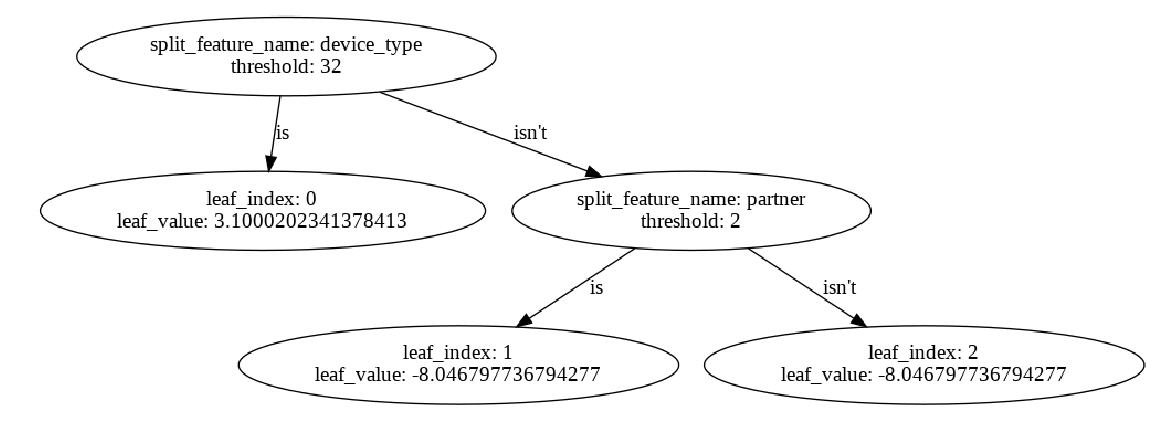

In [46]:
lgb.plot_tree(lgb_model, tree_index=100, figsize=(20, 20))

In [47]:
# Finding the accuracy
y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)

y_pred_max = np.argmax(y_pred, axis=1)

accuracy = sum(y_test == y_pred_max) / len(y_test)
print(accuracy)

0.9920759045850993


In [49]:
# Classification Report
classificationReport = classification_report(y_pred_max, y_test.values)

print(classificationReport)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     51955
           1       1.00      1.00      1.00      1196
           2       0.99      1.00      0.99     92679
           3       0.99      0.99      0.99    188110
           4       1.00      1.00      1.00      6588
           5       0.99      1.00      1.00     27520
           6       1.00      1.00      1.00      6707
           7       1.00      1.00      1.00       520
           8       1.00      1.00      1.00      5989
           9       0.99      1.00      0.99     47550
          10       0.99      1.00      0.99     83015
          11       0.20      0.98      0.34        98
          12       1.00      1.00      1.00     16814
          13       0.99      1.00      1.00     77523
          14       1.00      1.00      1.00       834
          15       1.00      0.99      1.00       363
          16       1.00      1.00      1.00       208
          17       1.00    

The precision, recall, f1-score for the majority classes are a 1. However for less than 1 percent of the total 135 classes it is 0.



### Feature importance testing

Let us also plot the feature importance based on (split) times used to split and information gain.

'Split' contains numbers of times the feature is used in a model.
'Gain' contains total gains of splits which use the feature.

Numeric values with a large range will end up in the split importance more usually over a binary feature because the model doesn't need to check a large range of values.

'hour', 'partner', 'month', 'audience', 'minute' are top features.

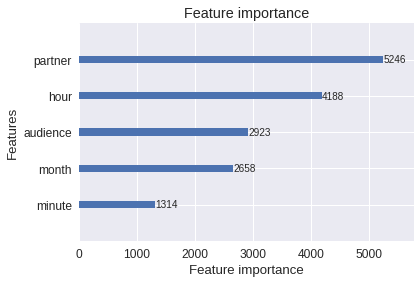

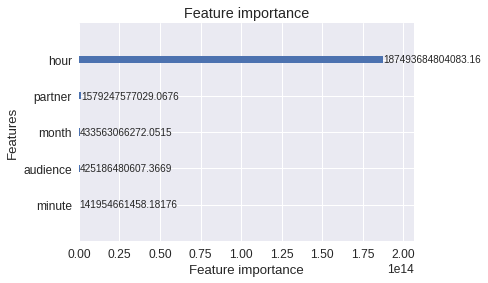

In [67]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=5)
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=5)

We started by importing selective rows of our BIG dataset and then heavily investigated the different behaviour and characteristics of the dataset. Then we looked at different ways of encoding the independent variables and employed the one best suited for our model. We implemented LightGBM and observed that the accuracy was over 99% yet some minority classes were not being recognised (although it was less than 1% of the prediction classes). We then performed feature importance testing to observe the top features which influenced our prediction. 

The model may be further improved if we tackle the data imbalance and also use the entire dataset instead of selective imports. Further, performign cross validation might also improve the results. 

Extensive feature engineering by Aggregates on various feature groups. Aggregates like count, count of unique values, delta with previous value, delta with next value. Time to next click when grouped by user could be used.

This concludes the data science challenge on clicks and conversions data.